In [48]:
import numpy as np
import pandas as pd

import nltk
from konlpy.tag import Okt

from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

In [2]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

In [3]:
label = LabelEncoder()
tokenizer = Okt()

In [4]:
politics_article = pd.read_csv('politics_article_result.csv')
culture_article = pd.read_csv('culture_article_result.csv')
economy_article = pd.read_csv('economy_article_result.csv')
science_article = pd.read_csv('science_article_result.csv')
society_article = pd.read_csv('society_article_result.csv')
world_article = pd.read_csv('world_article_result.csv')

In [6]:
news_data = pd.concat([politics_article,culture_article,economy_article,science_article,society_article,world_article])

df = news_data

label.fit(df['Category'])
label.transform(df['Category'])

df['Category'] = label.transform(df['Category'])

In [7]:


del_list = ['하다','있다','되다','이다','돼다','않다','그렇다','아니다','이렇다','어떻다','밝히다','열리다','없다','대해']
new_df = pd.DataFrame(columns=['Word', 'Category'])

# 주어진 DataFrame을 순회하면서 처리
for index, text in df.iterrows():
    word_title_list = []
    new_text = ''.join(text['Title']) + ''.join(text['Article'])
    text_tag = tokenizer.pos(new_text, norm=True, stem=True)

    # text_tag에서 Word와 Category를 추출하여 new_df에 추가
    for word, category in text_tag:
      if not category in ["Josa","Eomi","Punctuation","Foreign"]:
        if(len(word) != 1) & (word not in del_list):
          word_title_list.append(word)
    new_df = new_df.append({'Word': word_title_list, 'Category': text.Category}, ignore_index=True)

In [8]:
# 원하는 형태긴 하지만 이중for문이라 시간이 좀 걸린다.. 데이터 양이 더 많아진다면 시간이 더 걸릴테니 다른 방법도 생각해 보자
new_df

,Word,Category
0,"[이수정, 배현진, 여자, 피해자, 수도, 우발, 사건, 국민, 배현진, 의원, 서...",5
1,"[외교부, 부부, 방북, 수교, 75, 주년, 교류, 확대, 논의, 종합, 서울, ...",5
2,"[배현진, 테러, 여야, 증오, 정치, 멈추다, 정쟁, 진행형, 여야, 자성, 목소...",5
3,"[중대, 재해, 처벌, 유예, 불발, 야당, 무책임하다, 행위, 유감, 중소기업, ...",5
4,"[정의당, 비례대표, 이은주, 사직, 국회, 본회의, 가결, 정의당, 비례대표, 이...",5
...,...,...
305,"[밉다, 국방부, 북한, 무기, 지원, 크다, 장기, 우려, 미국, 국방부, 북한,...",4
306,"[미국, 이라크, 시리아, 미군, 철수, 준비, 미국, 이라크, 시리아, 주둔, 중...",4
307,"[2200달러, 디올, 여당, 흔들다, 외신, 집중, 조명, 연합뉴스, 윤석열, 대...",4
308,"[세계, 최대, 광산, 업체, 호주, BHP, 홍해, 우회, 항로, 채택, 예멘, ...",4


In [9]:
# 데이터 저장
data_result = new_df
data_result.to_csv('data_result.csv', index=False, encoding='utf-8')

In [10]:
original_to_new_labels = {0: 'IT/과학', 1: '경제', 2: '사회', 3: '사회/문화', 4: '세계', 5: '정치'}

In [11]:
data_result = pd.read_csv('data_result.csv')

데이터 최대 길이 : 13036
데이터 평균 길이 : 1575.8870967741937


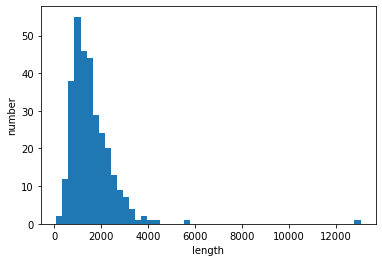

In [12]:
# 전체 텍스트 데이터 길이 분포 확인
print('데이터 최대 길이 :',max(len(a) for a in data_result['Word']))
print('데이터 평균 길이 :',sum(map(len, data_result['Word']))/len(data_result['Word']))

plt.hist([len(a) for a in data_result['Word']], bins=50)
plt.xlabel('length')
plt.ylabel('number')
plt.show()

In [13]:
# 모델 사용

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [15]:
vectorizer = TfidfVectorizer()

In [17]:
# 데이터 전처리
X = data_result['Word']
y = data_result['Category']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF를 사용하여 텍스트 데이터를 벡터화
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [22]:
# 모델 훈련 SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# 모델 평가
svm_y_pred = svm_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, svm_y_pred)
print(f"정확도: {accuracy}")

정확도: 0.9193548387096774


In [25]:
# 특정 단어 입력 예측
def predict_category(input_word):
    tokens = tokenizer.pos(input_word, norm=True, stem=True)
    input_sentence = ' '.join([word for word, _ in tokens])
    input_tfidf = vectorizer.transform([input_sentence])
    prediction = svm_model.predict(input_tfidf)
    return prediction[0]

# 예측 테스트
test_word = '북한 잠수함 밀집 신포 해상서 순항미사일 포착…나흘만에'
predicted_category = predict_category(test_word)

# 새로운 레이블로 변환
new_label = original_to_new_labels[predicted_category]

print(f" {new_label}")

 정치


In [26]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

In [27]:
# 모델 훈련
logreg_model = LogisticRegression()
logreg_model.fit(X_train_tfidf, y_train)


# 모델 평가
logreg_y_pred_logreg = logreg_model.predict(X_test_tfidf)
accuracy_logreg = accuracy_score(y_test, logreg_y_pred_logreg)
print(f"정확도: {accuracy_logreg}")

정확도: 0.9354838709677419


In [28]:
# 결정트리
from sklearn.tree import DecisionTreeClassifier

In [30]:
# 모델 학습
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_tfidf, y_train)

# 모델 평가
tree_y_pred_dt = tree_model.predict(X_test_tfidf)
accuracy_dt = accuracy_score(y_test, tree_y_pred_dt)
print(f"정확도: {accuracy_dt}")

정확도: 0.6774193548387096


In [31]:
# K-최소근접
from sklearn.neighbors import KNeighborsClassifier

In [33]:
# KNN 모델 학습
knn_model = KNeighborsClassifier(n_neighbors=3)  # K값은 3이 가장 정확도가 높음
knn_model.fit(X_train_tfidf, y_train)

# 모델 평가
knn_model_y_pred_dt = knn_model.predict(X_test_tfidf)
accuracy_dt = accuracy_score(y_test, knn_model_y_pred_dt)
print(f"정확도: {accuracy_dt}")

정확도: 0.9193548387096774
